# Testing possible atom mappings in perses
### Module to test how a hybrid system will be generated for a system

    * This does _not_ check if hydrogens are mapped or not. That is handled by class SmallMoleculeSetProposalEngine as a system needs to be generated and the hydrogens restraints need to be checked
    * AtomMapper also does not check that the minimal number of core atoms are retained by a map. If

In [1]:
# from perses.utils.openeye import createOEMolFromSDF
from perses.utils.smallmolecules import render_atom_mapping
from perses.utils.openeye import smiles_to_oemol
from perses.rjmc.topology_proposal import AtomMapper
from openeye import oechem
import itertools
from IPython.display import display, Image

In [2]:
# download files of interest from openmm-forcefields repo!
import os
os.system('wget https://raw.githubusercontent.com/openmm/openmmforcefields/master/openmmforcefields/data/perses_jacs_systems/bace/Bace_ligands_shifted.sdf')

0

#### Starting by just using the three default options in perses

INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...


Doing strong mapping
benzene ---> toluene ✓


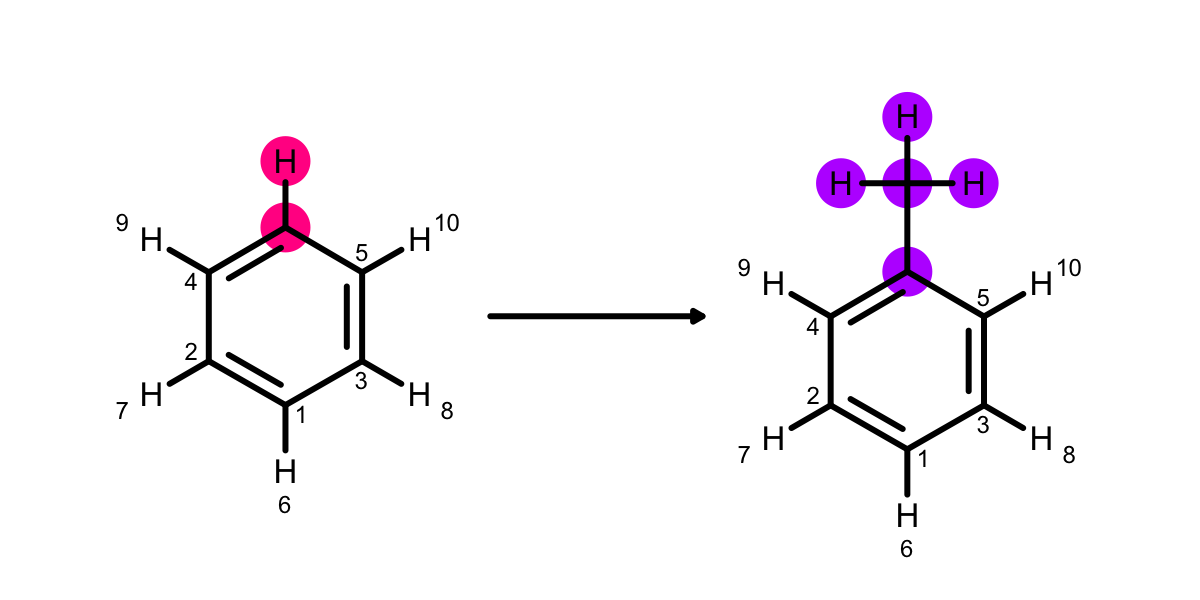

benzene ---> nitrobenzene ✓


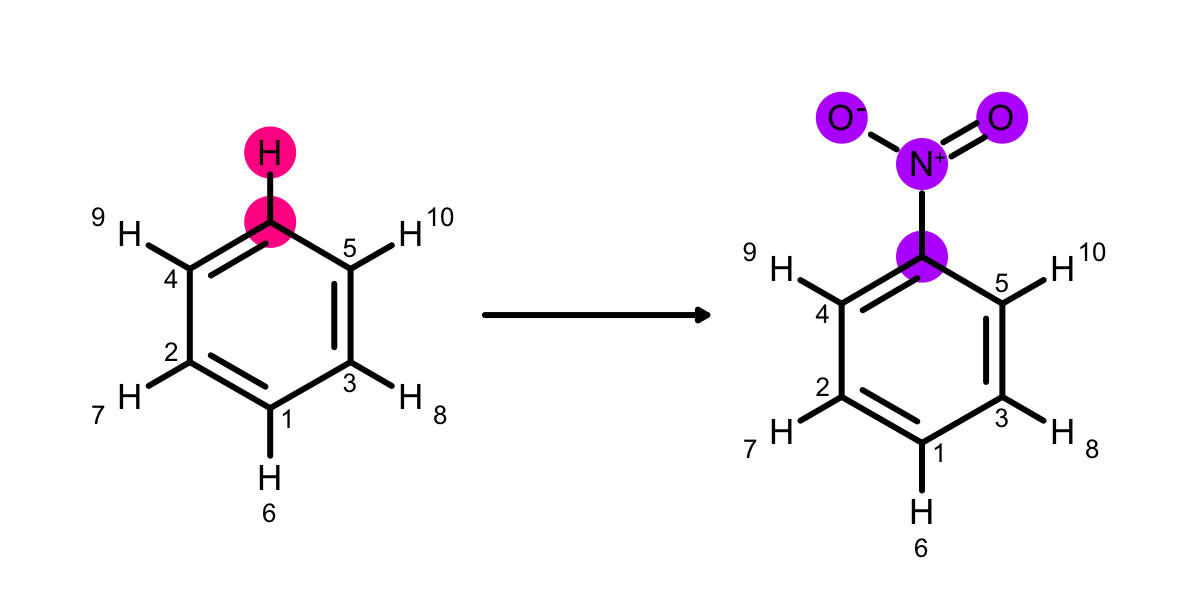

Cannot map benzene to cyclohexane effectively with strong map strength
toluene ---> nitrobenzene ✓


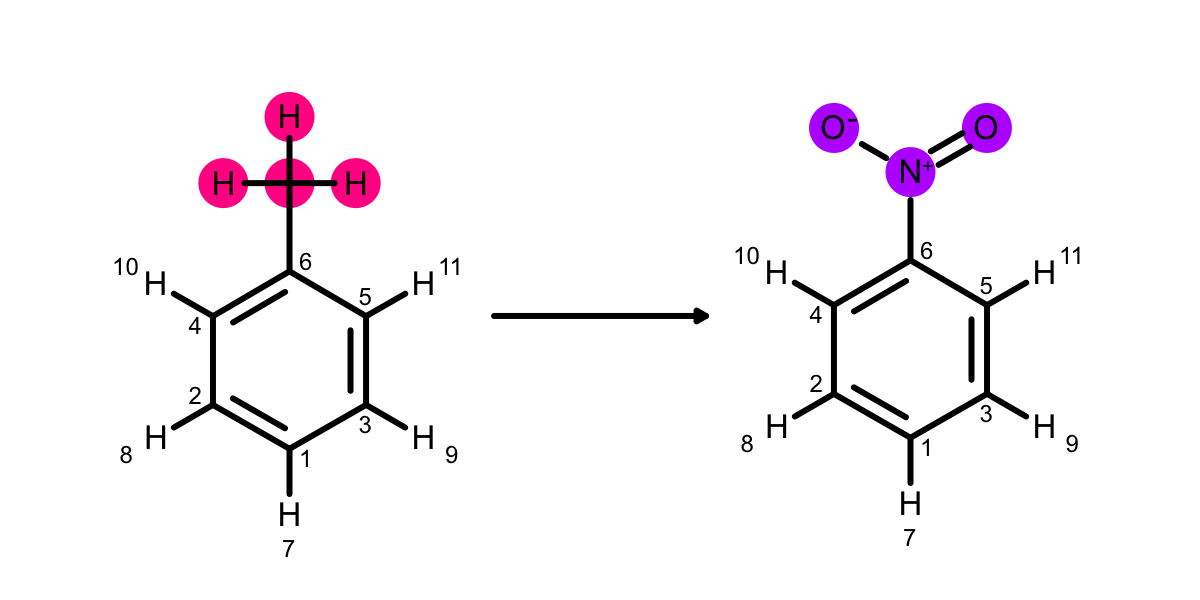

Cannot map toluene to cyclohexane effectively with strong map strength
Cannot map nitrobenzene to cyclohexane effectively with strong map strength



In [11]:
smiles = {'benzene':'c1ccccc1','toluene':'c1ccccc1C','nitrobenzene':'C1=CC=C(C=C1)[N+](=O)[O-]','cyclohexane':'C1CCCCC1'}
list_of_mols = []
for name,smi in smiles.items():
    mol = smiles_to_oemol(smi, title=name)
    list_of_mols.append(mol)


names_and_oemols = dict(zip(smiles.keys(),list_of_mols))

# looping over default mapping strengths
for map_strength in ['strong']:
    print(f'Doing {map_strength} mapping')
    for nameA,nameB in itertools.combinations(names_and_oemols,2):
        molA = names_and_oemols[nameA]
        molB = names_and_oemols[nameB]
        mapping = AtomMapper._get_mol_atom_map(molA,molB,map_strength=map_strength)

        if mapping is None or len(mapping) < 3:
            # too many unique atoms
            print(f'Cannot map {nameA} to {nameB} effectively with {map_strength} map strength')
        else:
            print(f'{nameA} ---> {nameB} '+u'\u2713')
            render_atom_mapping(f'{nameA}to{nameB}_{map_strength}.png', molA, molB, mapping)
            i = Image(filename=f'{nameA}to{nameB}_{map_strength}.png')
            display(i)
    print()

#### Now lets try a few different mapping schemes using openeye's `OEExprOpts`

https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemConstants/OEExprOpts.html

benzene ---> toluene ✓


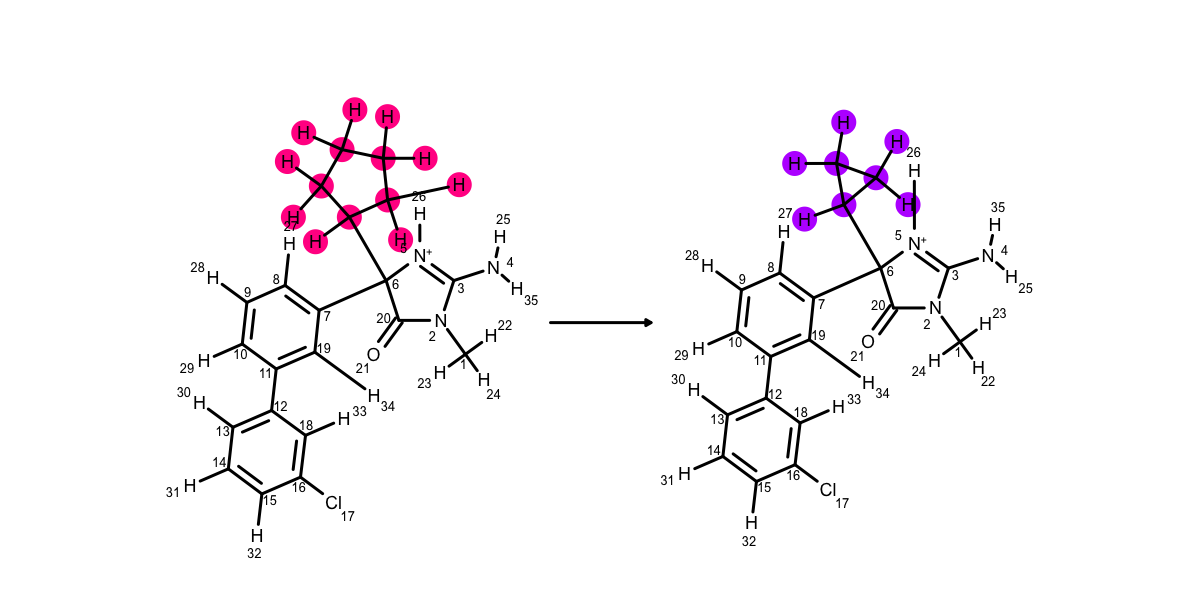


benzene ---> nitrobenzene ✓


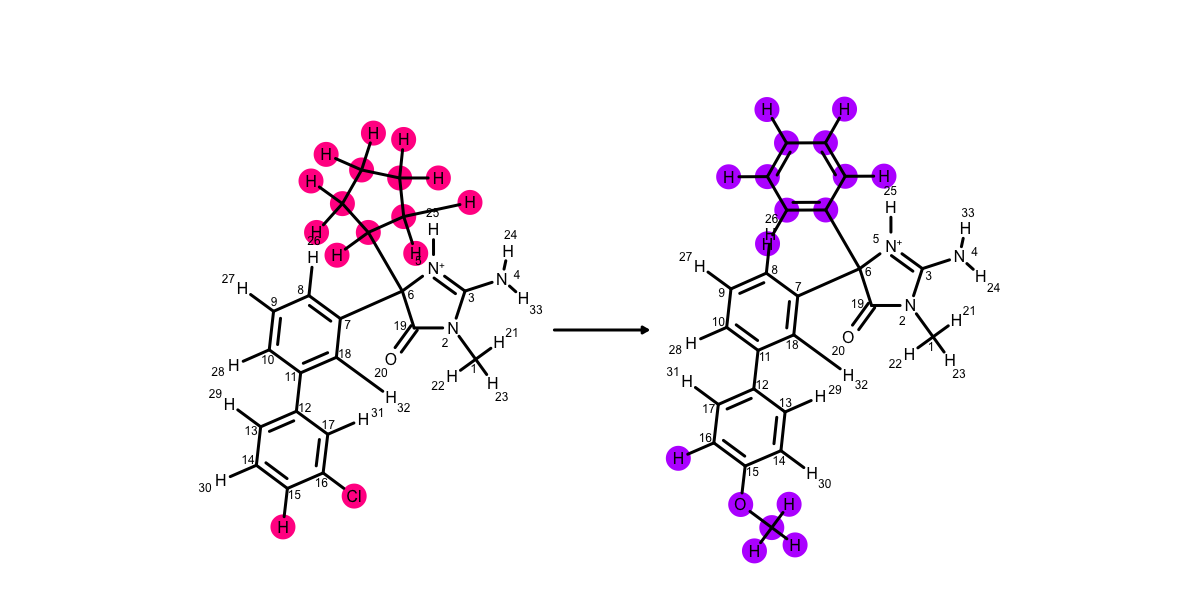


benzene ---> cyclohexane ✓


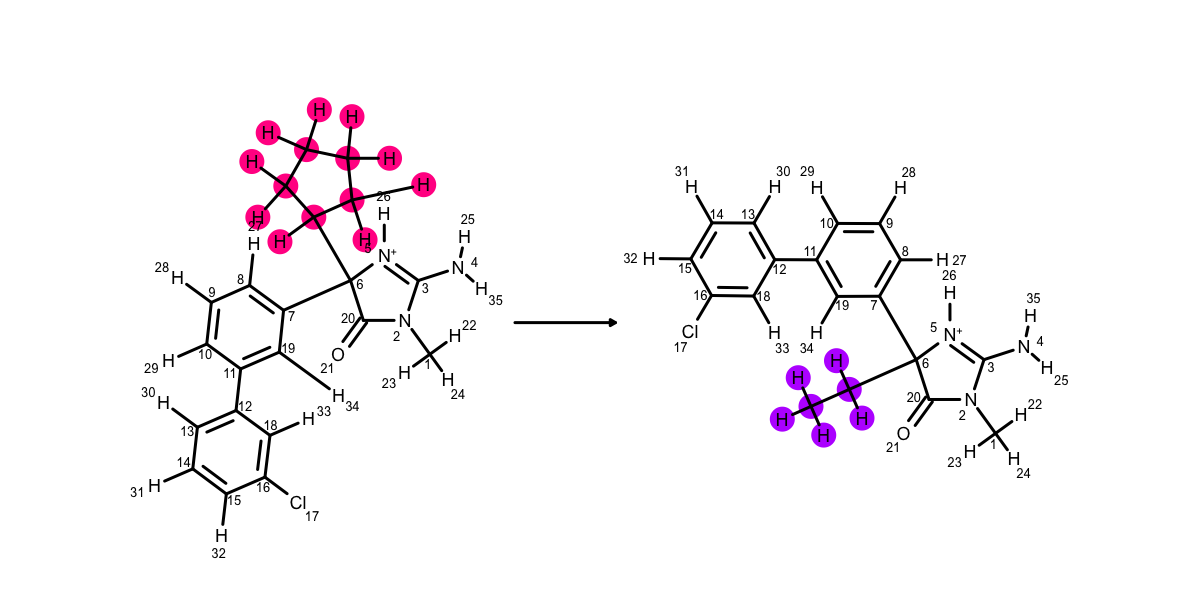


toluene ---> nitrobenzene ✓


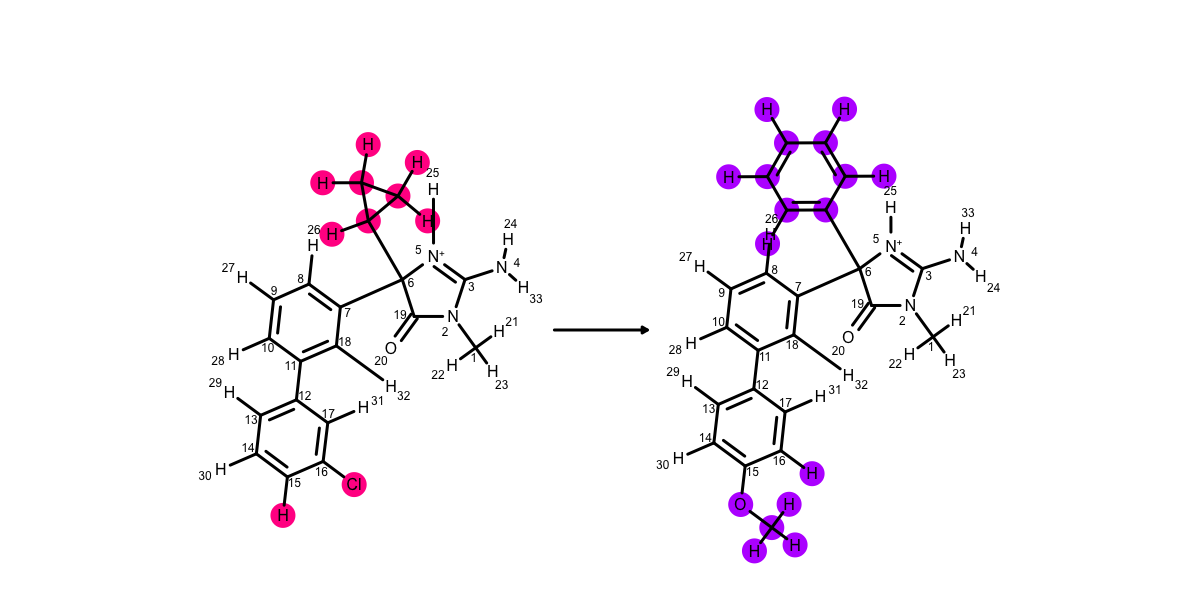


toluene ---> cyclohexane ✓


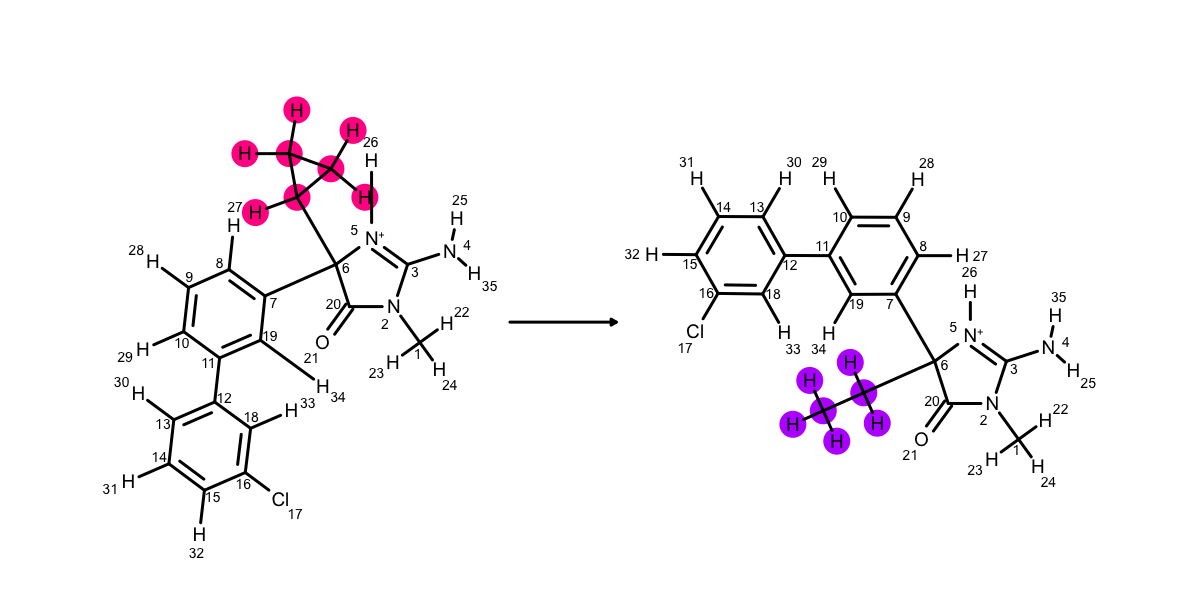


nitrobenzene ---> cyclohexane ✓


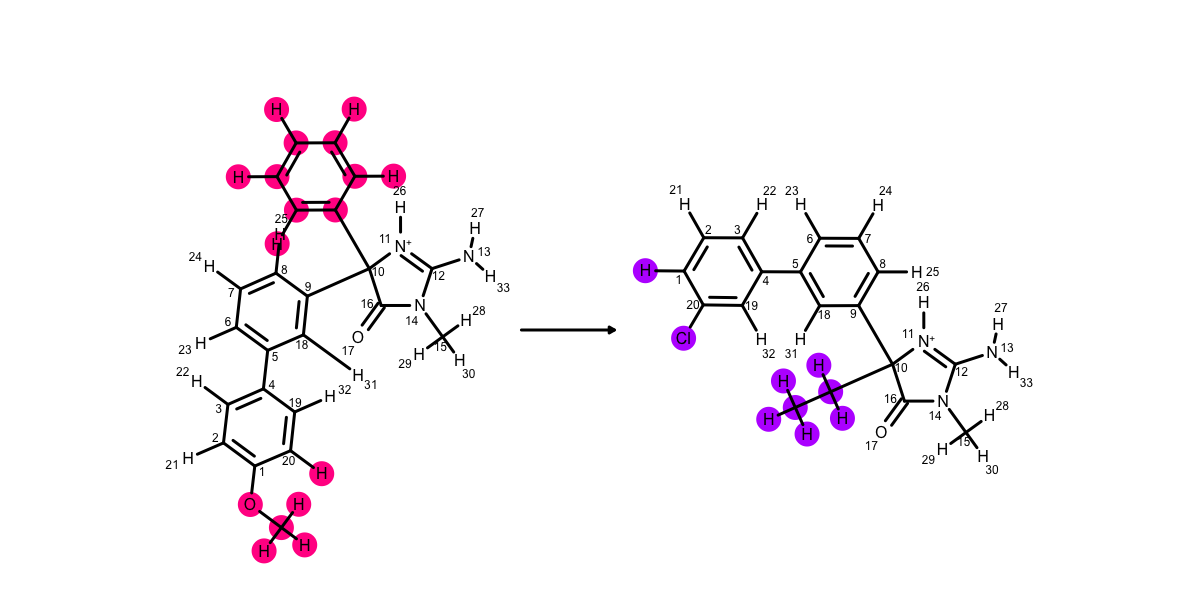

In [13]:
# this just checks atoms are in rings of the same size, with no check for aromaticity
atom_expr = oechem.OEExprOpts_IntType
bond_expr = oechem.OEExprOpts_RingMember 

from openforcefield.topology import Molecule
molecules = Molecule.from_file('Bace_ligands_shifted.sdf')
list_of_mols = [ molecule.to_openeye() for molecule in molecules ]

names_and_oemols = dict(zip(smiles.keys(),list_of_mols))

for nameA,nameB in itertools.combinations(names_and_oemols,2):
    molA = names_and_oemols[nameA]
    molB = names_and_oemols[nameB]    
    mapping = AtomMapper._get_mol_atom_map(molA,molB,atom_expr=atom_expr,bond_expr=bond_expr)
    
    print(f'{nameA} ---> {nameB} '+u'\u2713')
    render_atom_mapping(f'{nameA}to{nameB}.png', molA, molB, mapping)
    i = Image(filename=f'{nameA}to{nameB}.png')
    display(i)
    print()
    